# 시계열 데이터 준비

## 삼성전자

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

주식 가격으로는 close(종가)만 사용하고, 미래 날짜의 주식 가격을 예측하려고 하기 때문에 인덱스는 Date로 준비한다.

# 전처리

### 결측치 처리

.interpolate는 결측값을 보간하는 메소드이다. 소괄호 안 method='time'은 시계열 날짜 index를 기준으로 한다는 의미이다. 

In [2]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Time Series에서 결측치가 있는 부분만 판다스의 Series 자료형으로 출력했을 때 현재 다루는 자료에 결측치가 없는 걸 확인할 수 있다.

# 시계열 데이터의 Stationary 분석

### 정성적 분석 - 구간 통계치 시각화

In [3]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

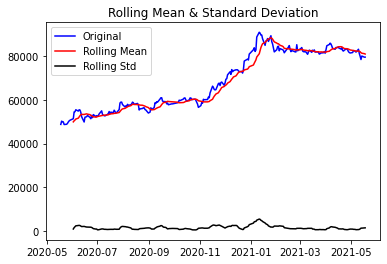

In [4]:
plot_rolling_statistics(ts, window=12)

정성적 분석을 위해 시각화를 수행한 결과, 시간의 추이에 따라 평균과 분산이 증가하는 패턴을 보이므로 이 시계열 데이터는 stationary하지 않다고 결론 내렸다.

### 정량적 분석 - ADF Test

In [5]:
from statsmodels.tsa.stattools import adfuller

# statmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 ADF Test를 수행하는 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


정량적인 분석을 위해 ADF Test를 수행한 결과 p-value가 약 0.66으로, 이 시계열 데이터가 stationary하다고 말할 수 없다 생각한다.

# 시계열 데이터를 Stationary하게 가공하기

### 로그 변환

In [7]:
ts_log = np.log(ts)

In [8]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 약 0.66에서 약 0.59 정도로 소폭 감소했다. 

### 시계열 분해(Time Series Decomposition)

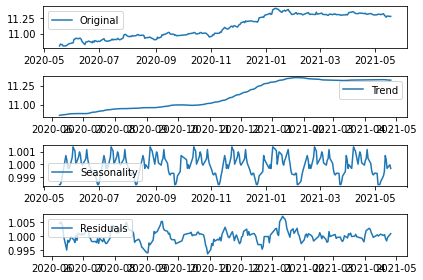

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Stationary 확인

In [10]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


p-value가 약 0.66에서 6.234854e-08로 낮아졌다.

# 학습, 테스트 dataset 생성

원본 데이터를 학습, 테스트 데이터로 분리한다.

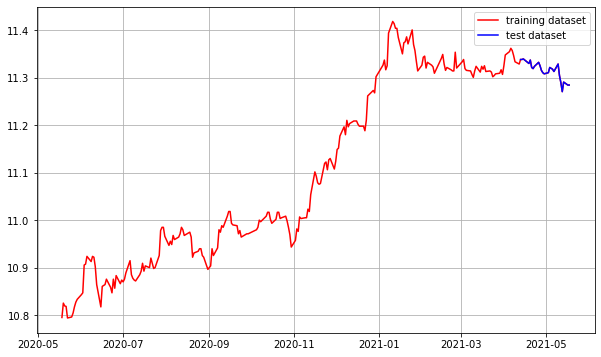

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 적정 ARIMA 모수 찾기

### ACF, PACF를 그려보고 p,q 구하기

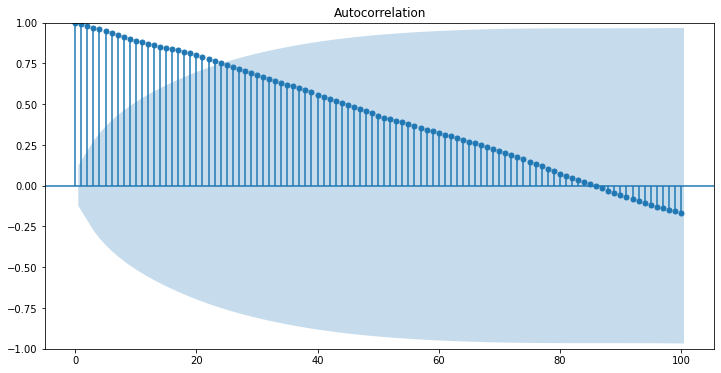

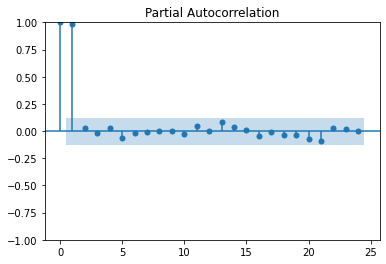

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

n, m = 12, 6
fig, ax = plt.subplots(figsize=(n, m))
plot_acf(ts_log, lags=100, ax=ax)
plot_pacf(ts_log, method='ywm')
plt.show()

pacf그래프를 보아 p는 1이 적합하다고 생각한다. p가 2 이상인 구간에서 pacf값이 급격하게 떨어지기 때문이다.   

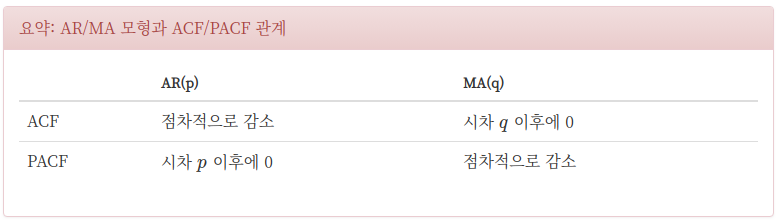

노드에서 나온 이 그래프를 오해해서, AR과 MA를 동시에 고려해야 한다고 생각했는데(p값과 q값과 모두 확인)   
많은 시계열 데이터가 AR이나 MA중 하나의 경향만 가지기 때문에, p나 q중 하나는 0이라고 이 표 이미지 바로 위에서 설명이 있었다.   
어쩐지 그래프 크기를 늘려가며 q값을 구해 넣어봤건만 그래프가 이상한 모양으로 나와서 왜 그럴까 고민했는데, 야작을 하던 같은 조의 빈님께서 위 사실을 상기시켜 주셨다(빈님은 1조의 동욱님께 관련해서 훌륭한 설명을 들으셨다고 한다, 나도 일단 exploration 제출하고 찾아봬야지!).   
이렇게 "야작만능설"에 또 하나의 논거를 얻어간다.

### 차분 안정성을 확인해 d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


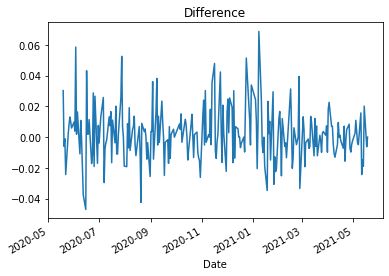

In [13]:
# 1차 차분 구하기
diff = ts_log.diff(periods=1).iloc[1:]
diff.plot(title='Difference')

augmented_dickey_fuller_test(diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


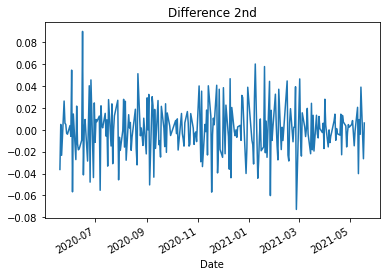

In [14]:
# 2차 차분 구하기
diff_2 = diff.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분 했을 때 보다 2차 차분했을 때 p-value의 값이 커졌다.   
즉 확률분포 상 극단적인 관측이 나올 확률이 증가했으므로, 차분은 도움이 되지 않는다고 생각했다.   
그러므로 d값은 0으로 한다.

# ARIMA 모델 훈련과 테스트

### 모델 빌드와 훈련

In [15]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 0)) # p값 = 2, d값 = 0, q값 = 0
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 583.409
Date:                Thu, 17 Feb 2022   AIC                          -1158.817
Time:                        14:05:23   BIC                          -1145.153
Sample:                             0   HQIC                         -1153.302
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.132     83.895      0.000      10.831      11.349
ar.L1          1.0296      0.061     16.764      0.000       0.909       1.150
ar.L2         -0.0350      0.062     -0.562      0.5

### 테스트 및 시각화

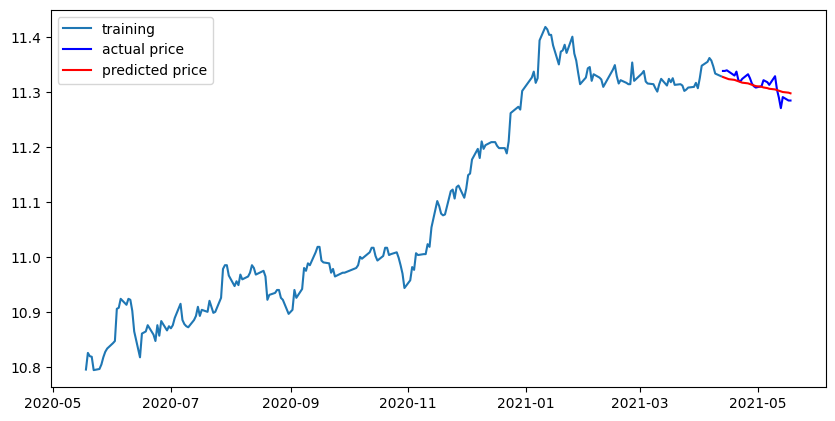

In [16]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# 시각화
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

시계열 데이터를 로그 변환하여 사용했으므로, np.exp()로 지수변환 후 계산해야한다.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1052831.3953688445
MAE:  840.325291750654
RMSE:  1026.0757259427028
MAPE: 1.02%


# 시계열 데이터 준비

## sk하이닉스

In [18]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/000660.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    130000.0
2021-02-18    126000.0
2021-02-19    133000.0
2021-02-22    136500.0
2021-02-23    138500.0
Name: Close, dtype: float64

# 전처리

### 결측치 처리

In [19]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Time Series에서 결측치가 있는 부분만 판다스의 Series 자료형으로 출력했을 때 현재 다루는 자료에 결측치가 없는 걸 확인할 수 있다.

# 시계열 데이터의 Stationary 분석

### 정성적 분석 - 구간 통계치 시각화

In [20]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

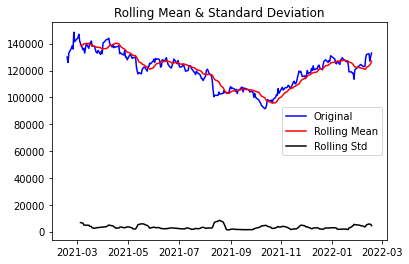

In [21]:
plot_rolling_statistics(ts, window=12)

정성적 분석을 위해 시각화를 수행한 결과, 시간의 추이에 따라 평균과 분산이 감소했다 증가하는(일정하지 않은) 패턴을 보이므로 이 시계열 데이터는 stationary하지 않다고 결론 내렸다.

### 정량적 분석 - ADF Test

In [22]:
from statsmodels.tsa.stattools import adfuller

# statmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 ADF Test를 수행하는 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [23]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.616722
p-value                          0.474448
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


정량적인 분석을 위해 ADF Test를 수행한 결과 p-value가 약 0.47로, 이 시계열 데이터가 stationary하다고 말할 수 없다 생각한다.

# 시계열 데이터를 Stationary하게 가공하기

### 로그 변환

In [24]:
ts_log = np.log(ts)

In [25]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.616722
p-value                          0.474448
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


p-value가 약 0.47에서 약 0.50 으로 오히려 소폭 증가했다.   
애초에 노드에서 "시간 추이에 따라 분산이 점점 커지는 특성을 보이는 시계열에서는 로그함수로 변환해주는 것이 도움이 된다"고 말하고 있어, 시간 추이에 따라 분산이 작아지다 다시 커지는 지금과 같은 경우는 (명제의 역이 항상 거짓인건 아니지만)사용하는 의미가 없다고 생각한다.

로그 처리로 오히려 p-value가 증가함을 확인했으므로, 로그 처리하지 않은 데이터를 사용하기로 했다.

### 시계열 분해(Time Series Decomposition)

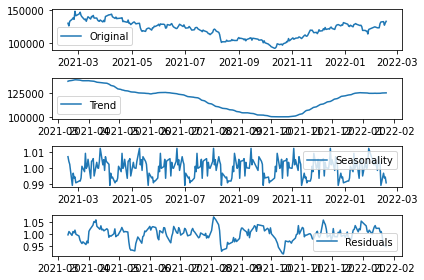

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Stationary 확인

In [27]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.516168
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


p-value가 약 0.47에서 0.000002로 낮아졌다.

# 학습, 테스트 dataset 생성

원본 데이터를 학습, 테스트 데이터로 분리한다.

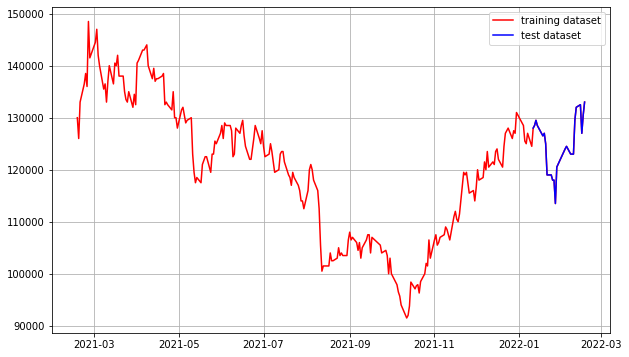

In [28]:
train_data, test_data = ts[:int(len(ts)*0.9)], ts[int(len(ts)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 적정 ARIMA 모수 찾기

### ACF, PACF를 그려보고 p,q 구하기

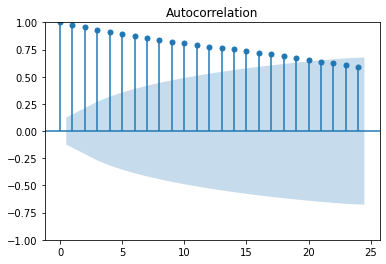

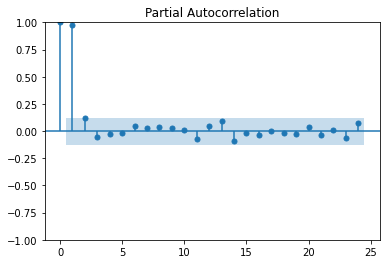

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts)
plot_pacf(ts, method='ywm')
plt.show()

pacf그래프를 보아 p는 1이 적합하다고 생각한다. p가 2 이상인 구간에서 pacf값이 급격하게 떨어지기 때문이다.   

### 차분 안정성을 확인해 d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.755984e+01
p-value                        4.101879e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


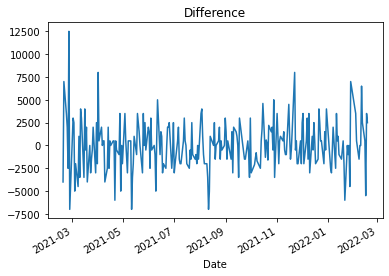

In [30]:
# 1차 차분 구하기
diff = ts.diff(periods=1).iloc[1:]
diff.plot(title='Difference')

augmented_dickey_fuller_test(diff)

Results of Dickey-Fuller Test:
Test Statistic                -8.836435e+00
p-value                        1.714137e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


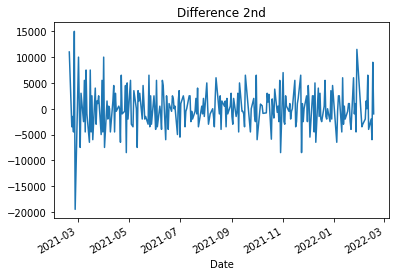

In [31]:
# 2차 차분 구하기
diff_2 = diff.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분 했을 때 보다 2차 차분했을 때 p-value의 값이 커졌다.   
즉 확률분포 상 극단적인 관측이 나올 확률이 증가했으므로, 차분은 도움이 되지 않는다고 생각했다.   
그러므로 d값은 0으로 한다.

# ARIMA 모델 훈련과 테스트

### 모델 빌드와 훈련

In [32]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 0)) # p값 = 2, d값 = 0, q값 = 0
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2073.734
Date:                Thu, 17 Feb 2022   AIC                           4155.467
Time:                        14:05:25   BIC                           4169.096
Sample:                             0   HQIC                          4160.969
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.203e+05   7702.024     15.615      0.000    1.05e+05    1.35e+05
ar.L1          0.8540      0.056     15.265      0.000       0.744       0.964
ar.L2          0.1255      0.056      2.225      0.0

### 테스트 및 시각화

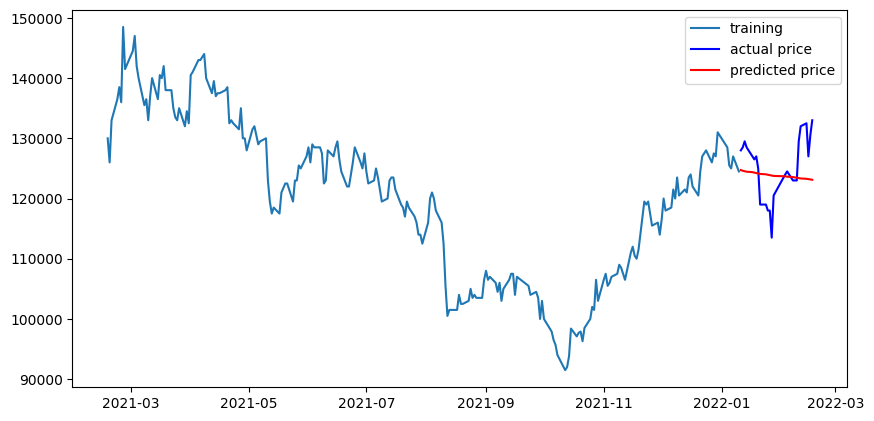

In [33]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# 시각화
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

시계열 데이터를 로그 변환하지 않고 사용했으므로, 지수변환 하지 않고 계산했다.

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)

mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  27595804.047825187
MAE:  4312.341609742418
RMSE:  5253.1708565232475
MAPE: 3.44%


# 시계열 데이터 준비

## 현대자동차

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005380.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    243500.0
2021-02-18    235500.0
2021-02-19    242000.0
2021-02-22    241500.0
2021-02-23    244500.0
Name: Close, dtype: float64

# 전처리

### 결측치 처리

In [36]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Time Series에서 결측치가 있는 부분만 판다스의 Series 자료형으로 출력했을 때 현재 다루는 자료에 결측치가 없는 걸 확인할 수 있다.

# 시계열 데이터의 Stationary 분석

### 정성적 분석 - 구간 통계치 시각화

In [37]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

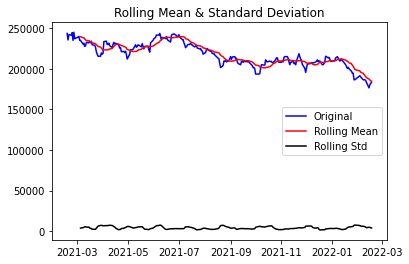

In [38]:
plot_rolling_statistics(ts, window=12)

정성적 분석을 위해 시각화를 수행한 결과, 시간의 추이에 따라 평균과 분산이 감소하는 패턴을 보이므로 이 시계열 데이터는 stationary하지 않다고 결론 내렸다.

### 정량적 분석 - ADF Test

In [39]:
from statsmodels.tsa.stattools import adfuller

# statmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 ADF Test를 수행하는 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [40]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.253993
p-value                          0.649949
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


정량적인 분석을 위해 ADF Test를 수행한 결과 p-value가 약 0.64로, 이 시계열 데이터가 stationary하다고 말할 수 없다 생각한다.

# 시계열 데이터를 Stationary하게 가공하기

시간 추이에 따라 분산이 점점 작아지는 특성을 보이는 시계열에서는 로그함수로 변환해주는 것이 도움이 되지 않을거라 생각해, 로그 변환은 거치지 않는다.

### 시계열 분해(Time Series Decomposition)

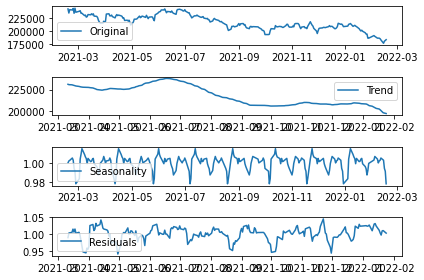

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Stationary 확인

In [42]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.938292e+00
p-value                        2.292943e-07
#Lags Used                     4.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


p-value가 약 0.64에서 2.292943e-07로 낮아졌다.

# 학습, 테스트 dataset 생성

원본 데이터를 학습, 테스트 데이터로 분리한다.

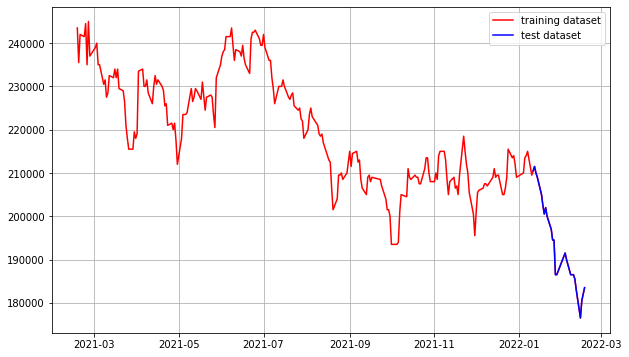

In [43]:
train_data, test_data = ts[:int(len(ts)*0.9)], ts[int(len(ts)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 적정 ARIMA 모수 찾기

### ACF, PACF를 그려보고 p,q 구하기

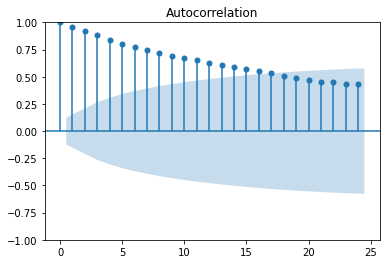

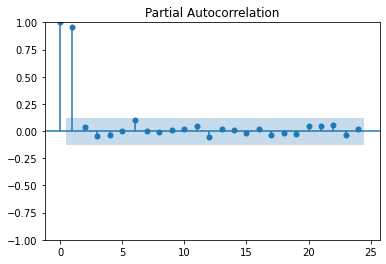

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts)
plot_pacf(ts, method='ywm')
plt.show()

pacf그래프를 보아 p는 1이 적합하다고 생각한다. p가 2 이상인 구간에서 pacf값이 급격하게 떨어지기 때문이다.   

### 차분 안정성을 확인해 d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.156041e+01
p-value                        3.280720e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


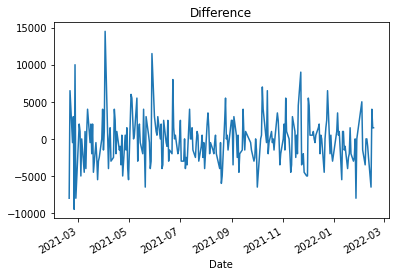

In [45]:
# 1차 차분 구하기
diff = ts.diff(periods=1).iloc[1:]
diff.plot(title='Difference')

augmented_dickey_fuller_test(diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.533577e+00
p-value                        3.526111e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


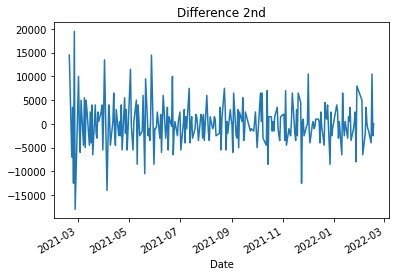

In [46]:
# 2차 차분 구하기
diff_2 = diff.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분 했을 때 보다 2차 차분했을 때 p-value의 값이 커졌다.   
즉 확률분포 상 극단적인 관측이 나올 확률이 증가했으므로, 차분은 도움이 되지 않는다고 생각했다.   
그러므로 d값은 0으로 한다.

# ARIMA 모델 훈련과 테스트

### 모델 빌드와 훈련

In [47]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 0)) # p값 = 2, d값 = 0, q값 = 0
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2125.532
Date:                Thu, 17 Feb 2022   AIC                           4259.063
Time:                        14:05:28   BIC                           4272.692
Sample:                             0   HQIC                          4264.565
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.205e+05   5580.071     39.514      0.000     2.1e+05    2.31e+05
ar.L1          0.9385      0.056     16.862      0.000       0.829       1.048
ar.L2          0.0312      0.055      0.566      0.5

### 테스트 및 시각화

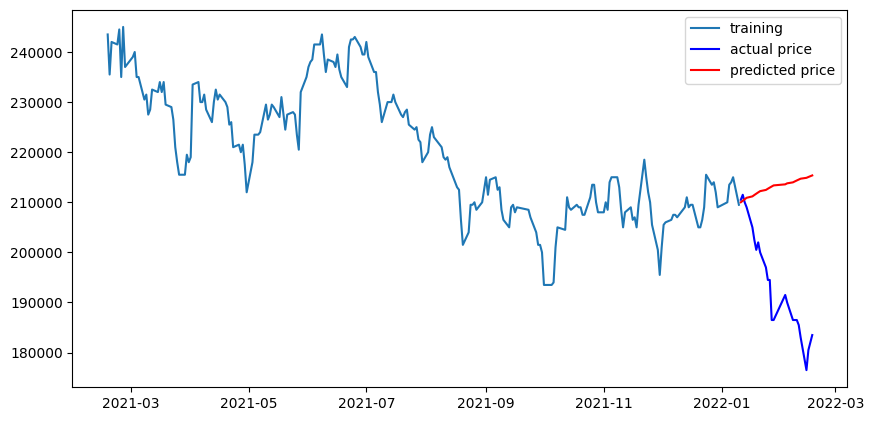

In [48]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# 시각화
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)

mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  512983569.38994735
MAE:  19439.228535442162
RMSE:  22649.140588330218
MAPE: 10.38%


# 회고

오늘도 야작을 하며 exploration을 진행했는데, 함께 야작하는 분들과 토론을 통해 많은 궁금증을 해소했다.     
     
시계열 분해를 통해 stationary를 확보한 residual을 얻었는데, ARIMA모델에서는 왜 로그 변환만 취한 ts_log를 사용하는지 같은 조의 지호님이 질문하셔서 "그냥 그렇구나"겉핥기로 넘어갔던 부분을 곰곰히 생각하는 시간을 가졌다.   
본문에서 "시계열 분해를 통해 얻은 residual이 예측력 있는 안정적인 시계열 데이터가 되는 것을 확인했고, 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있습니다."라고 언급하는것을 보니, ARIMA모델 내에 시계열 분해 연산이 포함되어 있으므로 로그 변환만 취한 값을 넣어주는 게 아닌가 생각했고, 앞서 residual을 얻는 과정을 관찰한 건 ARIMA모델 안에서 이와 같은 일련의 과정이 진행됨을 선행해 알려주려는 목적이라고 나름의 결론을 지어 공유했다.   
사실 이런 때 나는 보통 질문하거나 다른 분의 답변을 함께 듣고있는 입장인데, 오늘은 답변하는 쪽이어서 큰 자기 효용감을 느꼈다.    
    
또 sk하이닉스 주가 데이터는 로그변환을 하고 나니 p-value가 오히려 상승해서 다른 분들은 어떠셨는지 질문했는데, 같은 조의 빈님께서 본문에 "시계열이 시간 추이에 따라 분산이 점점 커지고 있는 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 됩니다."라고 적혀있는 것을 보아, 분산이 커지는 경우가 아니라면 사용했을 때 도움이 안 되는게 아닌가 의견을 말씀해주셨다.    
명제가 참일때 역이 항상 거짓인 것은 아니지만 빈님의 말씀이 설득력있다고 생각해서 로그 변환한 값과 로그 변환하지 않은 값을 둘 다 사용해봤다. 결과적으로 유의미한 mape의 차이가 없었기 때문에 시간 추이에 따라 분산이 커지는 경우가 아니라면 로그변환 없이 코드를 작성했다.    
여전히 "로그 변환 이후에 p-value 값이 커질수도 있는건가?"하는 의문이 남지만, 이건 p-value의 개념을 다시 보고 수학적으로 로그 변환이 하는 일이 무엇인지 찾아봐야 해결할 수 있을 것이므로 일단은 넘어가도록 한다.   
    
마지막으로 현재 맞닥뜨려 아직(과제 제출당일 11시 35분)도 모르겠는 문제로, 시각화한 예측 그래프는 제대로 예측을 못 하는 것 같은데 mape값은 10%정도로 나온다! 이건 검색어를 어떻게 써야할지도 난감하고, 어떻게든 생각해 낸 검색어를 사용해 검색해봐도 만족스러운 해답을 찾을 수 없다. mape값을 산출하는 기전에 대한 이해도가 지금보다 높아야 명쾌한 답을 얻을것으로 추정한다. 다른 분들과의 상의 끝에도 뾰족한 답변이 나오지 않아(오히려 지호님은 나와 비슷하게 그래프상으론 예측이 이상한테 mape값은 꽤 낮은 결과가 있었다) 결국은 '루브릭 기준을 충족...한건가?'라는 마음으로 제출하려고 한다.   
    
다 적고보니 본문에서 답을 얻을 수 있는 문제이자, 그걸 기억하고 계시는 다른분에 의해 빠르게 해결한 문제들이다.   
"빠르게 맥락만 파악한다"가 "머리에 남는 것이 없을 정도로 대충 본다"가 되지 않도록 주의해야겠다.   
그리고 동료학습의 중요성을 그 언제보다 크게 느꼈으므로 앞으로도 (특히 exploration제출일에는)야작에 자주 참여해봐야겠다.